In [66]:
import pandas as pd


df = pd.read_csv("/Users/yusufshaikh/Downloads/adult23csv/adult23.csv")

In [67]:
column_mapping = {
    
    'RECTYPE': 'record_type',
    'HHX': 'household_number',
    
    # ANX
    'ANXEV_A': 'anxiety_disorder',
    'ANXFREQ_A': 'anxiety_frequency',
    'ANXMED_A': 'takes_med_for_anxiety',
    
    # DEP
    'DEPEV_A': 'depression',
    'DEPFREQ_A': 'depression_frequency',
    'DEPMED_A': 'takes_med_for_depression',
    
    # MHC
    'MHRX_A': 'medication_for_other_mental_health',
    'MHTHRPY_A': 'received_therapy_past_12mo',
    'MHTHDLY_A': 'delayed_therapy_due_to_cost',
    'MHTHND_A': 'needed_therapy_but_did_not_get',
    
    # general questions
    'PREGNOW_A': 'pregnant_now',
    'HEIGHTTC_A': 'height_in',
    'WEIGHTLBTC_A': 'weight_lb',
    'BMICAT_A': 'bmi_category',
    
    # NAT
    'NATUSBORN_A': 'born_in_us_or_territory',
    'YRSINUS_A': 'years_in_us',
    'CITZNSTP_A': 'citizenship_status',
    
    # SCH
    'SCHCURENR_A': 'currently_in_school',
    
    # FOO: Food Programs
    'FSNAP12M_A': 'received_snap_past_12mo',
    
    # FDS: Food Security
    'FDSRUNOUT_A': 'worried_food_would_run_out',
    'FDSLAST_A': 'food_did_not_last',
    'FDSBALANCE_A': 'could_not_afford_balanced_meals',
    'FDSSKIP_A': 'skipped_or_cut_meals',
    'FDSLESS_A': 'ate_less_than_should',
    'FDSHUNGRY_A': 'hungry_due_to_lack_of_money',
    'FDSCAT3_A': 'food_security_level_3cat',
    'FDSCAT4_A': 'food_security_level_4cat',
    
    # Other
    "AGE65": "age_65_plus",
    "SEX_A": "sex",
    "PAYBLL12M_A": "problems_paying_bills",
    "SMKNOW_A": "current_smoker",
    "EMPWRKFT1_A": "work_35_plus_hours",
    
}

In [68]:
# Filter and rename
df = df[list(column_mapping.keys())].rename(columns=column_mapping)
# df.head()

In [69]:
# df.info()

In [70]:
# Non-null count for each column
print(df.notnull().sum())

record_type                           29522
household_number                      29522
anxiety_disorder                      29522
anxiety_frequency                     29522
takes_med_for_anxiety                 29522
depression                            29522
depression_frequency                  29522
takes_med_for_depression              29522
medication_for_other_mental_health    23792
received_therapy_past_12mo            29522
delayed_therapy_due_to_cost           29522
needed_therapy_but_did_not_get        29522
pregnant_now                           6717
height_in                             29522
weight_lb                             29522
bmi_category                          29522
born_in_us_or_territory               29522
years_in_us                            4702
citizenship_status                    29522
currently_in_school                   29522
received_snap_past_12mo               29522
worried_food_would_run_out            29522
food_did_not_last               

In [71]:
# define target variable
df["psych_distress"] = ((df["anxiety_frequency"] >= 2) | (df["depression_frequency"] >= 2)).astype(int)

In [72]:
features = [
    "food_security_level_3cat",
    "received_snap_past_12mo",
    "worried_food_would_run_out",
    "food_did_not_last",
    "could_not_afford_balanced_meals",
    "skipped_or_cut_meals",
    "ate_less_than_should",
    "hungry_due_to_lack_of_money",
    "currently_in_school",
    "citizenship_status",
    "born_in_us_or_territory",
    "bmi_category",
    "age_65_plus",
    "sex",
    "problems_paying_bills",
    "current_smoker",
    "work_35_plus_hours",
]

In [73]:
X = df[features]
y = df["psych_distress"]

In [74]:
numeric_features = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Fill missing numeric with median, categorical with 'missing'
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [76]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ]
)

In [77]:
from collections import Counter


counter = Counter(y)
neg, pos = counter[0], counter[1]
scale = neg / pos

print(f"Class 0 count: {neg}, Class 1 count: {pos}, scale_pos_weight: {scale:.2f}")

Class 0 count: 960, Class 1 count: 28562, scale_pos_weight: 0.03


In [78]:
from xgboost import XGBClassifier

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale))
])

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
clf.fit(X_train, y_train)

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [10:49:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['food_security_level_3cat',
                                                   'received_snap_past_12mo',
                                                   'worried_food_would_run_out',
                                                   'food_did_not_last',
                                                   'could_not_afford_balanced_meals',
                                                   'skipped_or_cut_meals',
                                                   'ate_less_than_should',
                                                   'hung...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [81]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.08      0.57      0.14       190
           1       0.98      0.78      0.87      5715

    accuracy                           0.77      5905
   macro avg       0.53      0.67      0.50      5905
weighted avg       0.95      0.77      0.85      5905



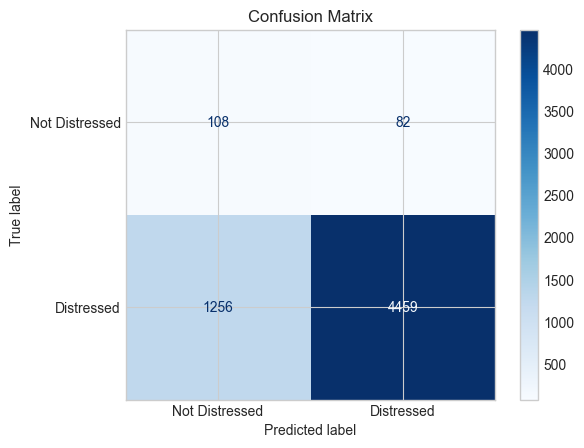

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Distressed", "Distressed"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


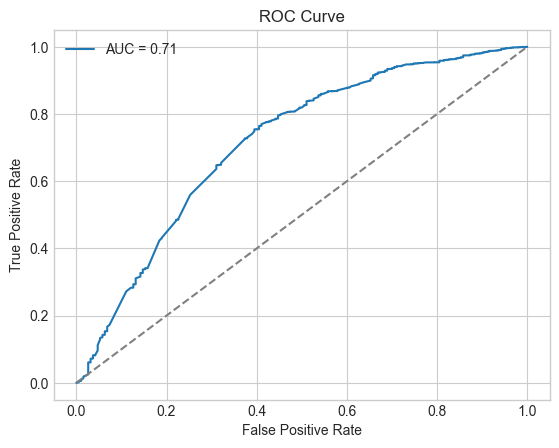

In [83]:
from sklearn.metrics import roc_curve, roc_auc_score

y_probs = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


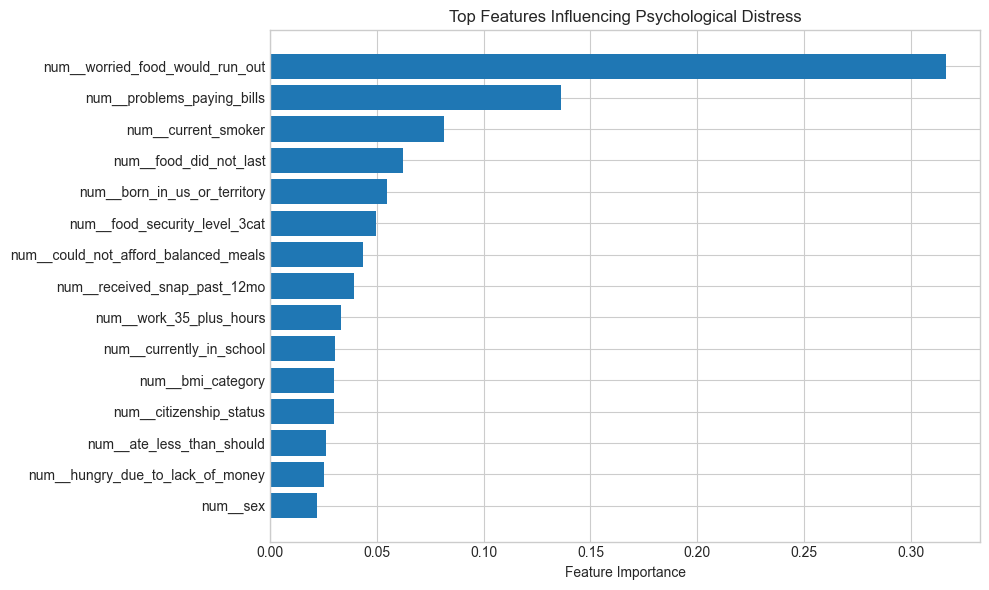

In [84]:
import numpy as np

# 1. Get trained model and preprocessor from pipeline
model = clf.named_steps["classifier"]
preprocessor = clf.named_steps["preprocessor"]

# 2. Get processed feature names
feature_names = preprocessor.get_feature_names_out()

# 3. Get feature importances
importances = model.feature_importances_

# 4. Sort and select top 15
sorted_idx = np.argsort(importances)[-15:]
top_features = feature_names[sorted_idx]
top_importances = importances[sorted_idx]

# 5. Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances)
plt.style.use("seaborn-v0_8-whitegrid")
plt.xlabel("Feature Importance")
plt.title("Top Features Influencing Psychological Distress")
plt.grid(True)
plt.tight_layout()
plt.show()

In [85]:
import numpy as np
import pandas as pd

# 1. Get trained model and preprocessor from pipeline
model = clf.named_steps["classifier"]
preprocessor = clf.named_steps["preprocessor"]

# 2. Get processed feature names
feature_names = preprocessor.get_feature_names_out()

# 3. Get feature importances and normalize to sum to 100
importances = model.feature_importances_
percentages = 100 * importances / importances.sum()

# 4. Create a sorted DataFrame of top features
feature_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance (%)": percentages
}).sort_values(by="Importance (%)", ascending=False)

# 5. Display top 15
print(feature_df.head(15).to_string(index=False))


                             Feature  Importance (%)
     num__worried_food_would_run_out       31.664032
          num__problems_paying_bills       13.602037
                 num__current_smoker        8.140837
              num__food_did_not_last        6.205684
        num__born_in_us_or_territory        5.491397
       num__food_security_level_3cat        4.945540
num__could_not_afford_balanced_meals        4.330214
        num__received_snap_past_12mo        3.937323
             num__work_35_plus_hours        3.342000
            num__currently_in_school        3.025691
                   num__bmi_category        3.003635
             num__citizenship_status        3.002461
           num__ate_less_than_should        2.623754
    num__hungry_due_to_lack_of_money        2.531649
                            num__sex        2.186778


In [86]:
sample_input = {
  "food_security_level_3cat": 2,
  "received_snap_past_12mo": 1,
  "worried_food_would_run_out": 1,
  "food_did_not_last": 1,
  "could_not_afford_balanced_meals": 1,
  "skipped_or_cut_meals": 1,
  "ate_less_than_should": 1,
  "hungry_due_to_lack_of_money": 1,
  "currently_in_school": 0,
  "citizenship_status": 2,
  "born_in_us_or_territory": 1,
  "bmi_category": 3,
  "age_65_plus": 0,
  "sex": 2,
  "problems_paying_bills": 1,
  "current_smoker": 1,
  "work_35_plus_hours": 0
}


In [87]:
# === Convert to DataFrame ===
X_person = pd.DataFrame([sample_input])

In [88]:
# === Predict with the trained pipeline model ===
pred_label = clf.predict(X_person)[0]
pred_prob = clf.predict_proba(X_person)[0][1]

In [89]:
# === Print results ===
print("Prediction:", "Distressed" if pred_label == 1 else "Not Distressed")
print("Probability of distress:", round(pred_prob, 3))

Prediction: Not Distressed
Probability of distress: 0.34
